In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import squidpy as sq
import matplotlib.pyplot as plt
from scipy import spatial
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import fdrcorrection

%matplotlib inline

/opt/miniconda3/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# Data

**TODO**: introduction from image to matrix

In this notebook, we work with data from the [`squidpy`](https://squidpy.readthedocs.io/en/stable/api.html) documentation to introduce `squidpy`'s functionalities for spatial statistics on omics data. In particular, we work with MERFISH data from [Moffitt et al.](https://doi.org/10.1126/science.aau5324).

The data stored in the form of an [`AnnData`]() object. 

![AnnData object structure](imgs/anndata_schema.png "AnnData object structure")

It contains eight attributes

1. `X`: `scipy.csr_matrix`, count matrix (cells x genes)
2. `obs`: `pandas.DataFrame`, metadata for cells (same order as rows of `X`)
3. `var`: `pandas.DataFrame`, metadata for genes (same order as columns of `X`)
4. `obsm`: `dict`,
5. `obsp`: `dict`, pairwise data for observations
4. `varm`: `dict`,
5. `varp`: `dict`, pairwise data for variables
6. `uns`: `dict`, additional unstructured information


Note that not every `AnnData` object necessarily contains all of these attributes.

We start by getting an overview of the data.

In [2]:
# load dataset from within squidpy
# an external AnnData object is usually loaded with anndata.read_h5ad(<filename>)
merfish = sq.datasets.merfish()
# show an overview
merfish
# TODO: external

AnnData object with n_obs × n_vars = 73655 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch'
    uns: 'Cell_class_colors'
    obsm: 'spatial', 'spatial3d'

# Basic visualizations

We can see that our dataset contains 73655 cells and 161 genes.

The spatial coordinates per cell are stored in `obsm['spatial']`. Additionally, the cell centroids are stored in `obs`.

In [3]:
def subset_by_coordinates(adata: ad.AnnData, max_x: float, max_y: float, spatial_key: str = "spatial") -> ad.AnnData:
    x_mask = adata.obsm[spatial_key][:, 0] < max_x
    y_mask = adata.obsm[spatial_key][:, 1] < max_y
    mask = x_mask & y_mask
    return ad.AnnData(
        X=adata.X[mask, :],
        obs=adata.obs.iloc[mask, :],
        uns=adata.uns,
        obsm={k: v[mask, :] for k, v in adata.obsm.items()}
    )

In [4]:
merfish_subset = subset_by_coordinates(merfish, 0.2, 0.2)

# Neighbor graphs with `squidpy.gr`

The `squidpy.gr` module implements different functionalities based on spatial neigbhor graphs.<br>
Most spatial statistics are build around neighbor graphs, as they allow to compare statistics between samples with different scales.

Note that this part of the tutorial focuses on spatial statistics between cells *not* individual molecules.<br>
The main idea, however, is also applicable to single-molecule analyses.

## Computing neighbor graphs

We begin by looking at different ways to compute spatial neighborhood graphs.

**kNN Graph**<br>
**Delaunay Triangulation**<br>
**Radius**

In [5]:
def plot_neighbor_graph(adata, connectivity_key: str, spatial_key: str = "spatial", ax=None, subset=None) -> plt.axis:
    if ax is None:
        _, ax = plt.subplots(figsize=(10,10))

    if subset is None:
        connect = adata.obsp[connectivity_key].tocoo()
        coords = adata.obsm[spatial_key]
    else:
        connect = adata.obsp[connectivity_key][subset, subset].tocoo()
        coords = adata.obsm[spatial_key][subset, :]
        
    for i, j in tqdm(zip(connect.row, connect.col), total=connect.nnz, desc="Edges"):
        ax.plot(coords[[i,j], 0], coords[[i,j], 1], c="tab:grey")
    ax.scatter(coords[:, 0], coords[:, 1], c="tab:blue")

    return ax

In [6]:
sq.gr.spatial_neighbors(merfish_subset, delaunay=False, n_neighs=5)
sq.gr.spatial_neighbors(merfish_subset, delaunay=False, n_neighs=10, key_added="knn10")
sq.gr.spatial_neighbors(merfish_subset, delaunay=True, key_added="delaunay")

Edges:   0%|          | 0/13340 [00:00<?, ?it/s]

Edges:   0%|          | 0/26680 [00:00<?, ?it/s]

Edges:   0%|          | 0/15956 [00:00<?, ?it/s]

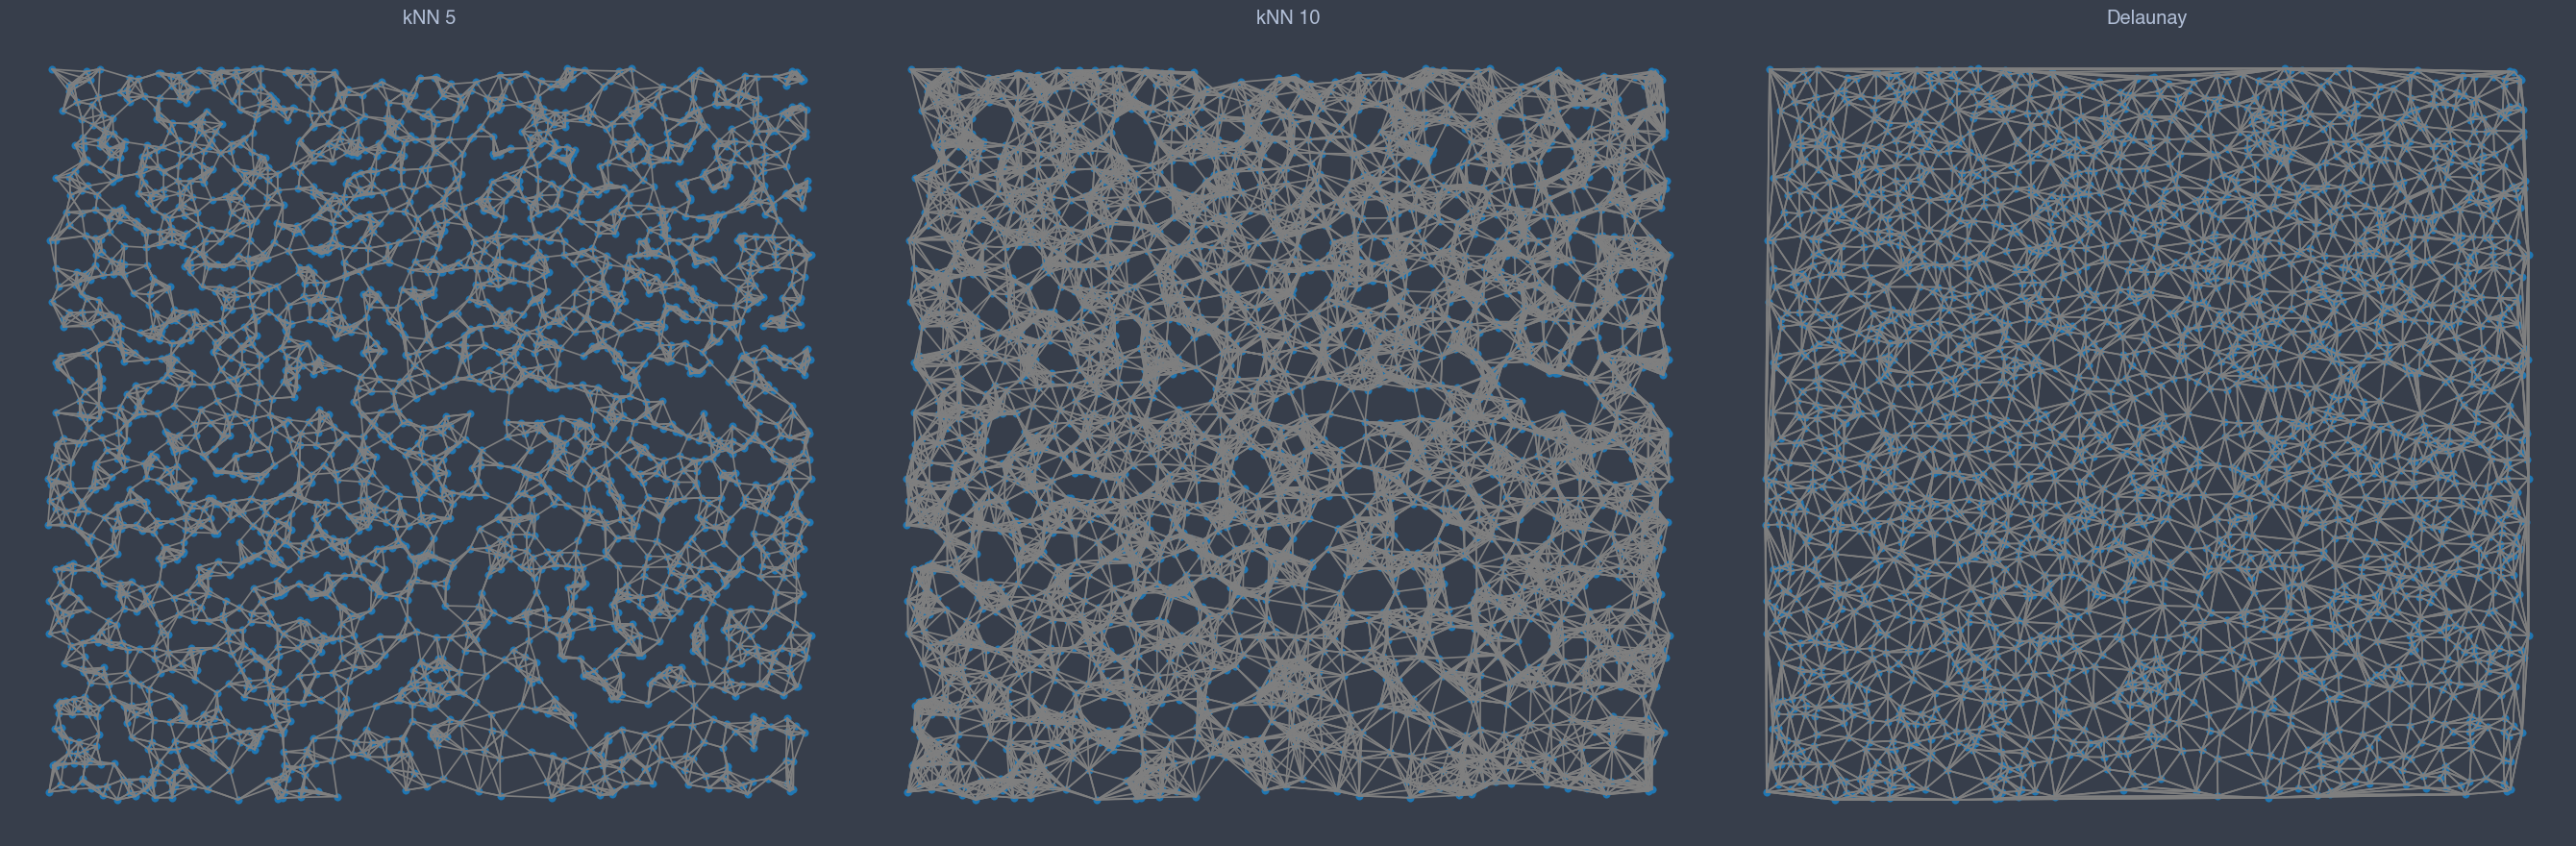

In [7]:
# TODO: find a good way to subset => compute everything on a subset!
fig, axes = plt.subplots(figsize=(27, 9), ncols=3)

for ax, title, key in zip(axes, ["kNN 5", "kNN 10", "Delaunay"], ["spatial", "knn10", "delaunay"]):
    plot_neighbor_graph(merfish_subset, f"{key}_connectivities", ax=ax)
    ax.set_title(title)
    ax.set_axis_off()

plt.tight_layout()
plt.show()
plt.close(fig)

## Ripley's Statistics

**TODO** 

Ripley's statistics calculate the probability of two points being closer than a certain threshold in a neighbor graph.

### Ripley's L/K

Ripley's K is defined as
$$ K(t) = \lambda^{-1} \sum_{i \neq j} \frac{I(d(i,j) < t)}{n} $$

where $d(\cdot,\cdot)$ is a distance metric and $I(\cdot)$ is a Kronecker delta-like function outputting 1 if the conditions is true and 0 otherwise.<br>
**TODO**: define $\lambda$ and $n$<br>
It represents the fraction of 

$K$ is turned into $L$ via variance-stabilizing transformation

$$ L(t) = (\frac{K(t)}{\pi})^{1/2} $$

### Ripley's F/G

$$R(t) = P(d(i,j) \leq t)$$
Where $R(t) = F(t)$ if $d(\cdot,\cdot)$ is the distance to a random *Poisson Point Process* and $R(t) = G(t)$ if $d(\cdot,\cdot)$ is a ``regular'' distance metric, typically euclidean distance.


### Notes on the `squidpy` implementation

**TODO**<br>
subsampling $\Rightarrow$ seed<br>
n_neigbhors<br>
max_dist

In [8]:
ripley_f = sq.gr.ripley(merfish, "Cell_class", mode="F", copy=False)
ripley_g = sq.gr.ripley(merfish, "Cell_class", mode="G", copy=False)
ripley_l = sq.gr.ripley(merfish, "Cell_class", mode="L", copy=False)

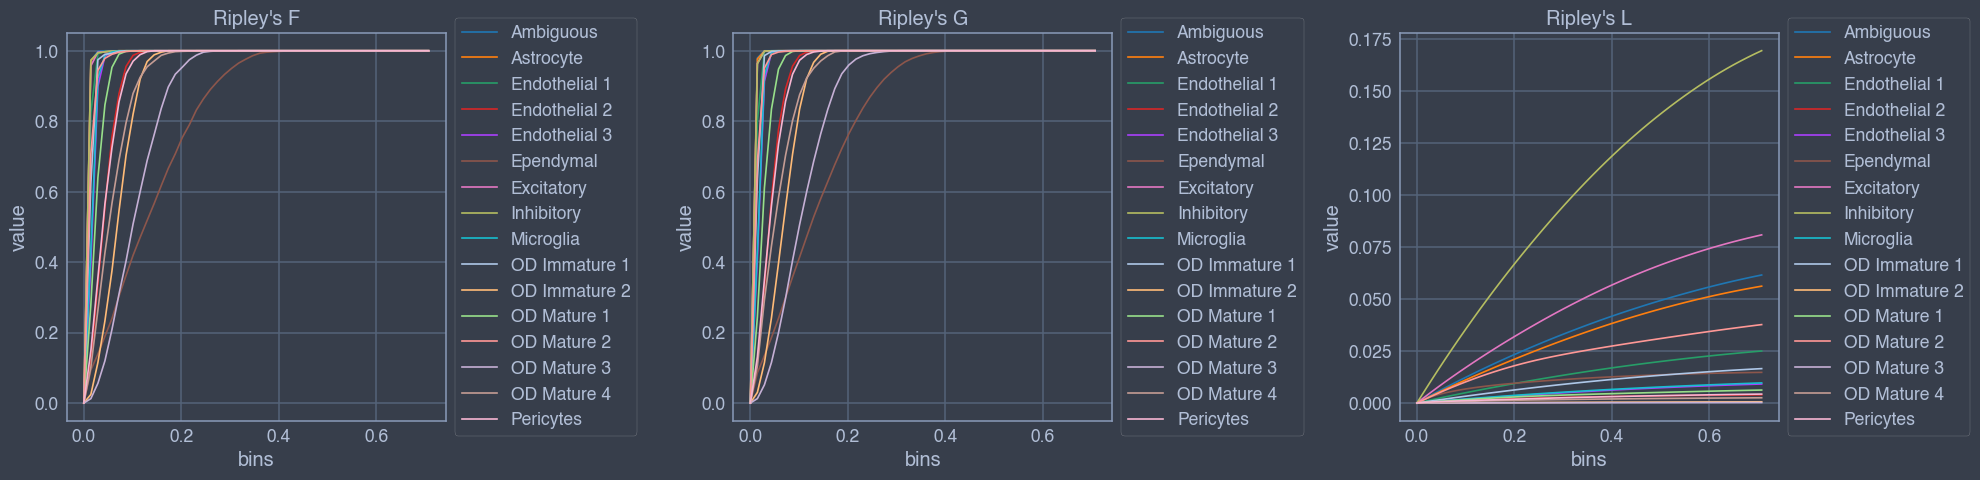

In [9]:
fig, axes = plt.subplots(figsize=(20, 5), ncols=3)

for i, (ax, mode) in enumerate(zip(axes, ["F", "G", "L"])):
    sq.pl.ripley(merfish, cluster_key="Cell_class", mode=mode, ax=ax)
    ax.set_title(f"Ripley's {mode}")

plt.tight_layout()
plt.show()
plt.close(fig)

## Spatial Autocorrelation

Spatial autocorrelation metrics implemented in `squidpy` are Moran's I and Geary's C.

**TODO**: optional implementation

**Moran's I**<br>
$I = \frac{N}{W} \frac{\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}(x_i - \bar{x})(x_j - \bar{x})}{\sum_{i=1}^{n}(x_i - \bar{x})^2}$


With
* $N$ = number of spatial units, i.e. cells
* $x_i$ = value of variable at location $i$, i.e. the position of a cell
* $\bar{x}$ = mean of variable $x$, i.e. the centroid of a cell population
* $w_{ij}$ = spatial weight between locations $i$ and $j$, i.e. the edge weight in the spatial graph
* $W = \sum_{i=1}^{N}\sum_{j=1}^{N}w_{ij}$ i.e. the sum of all weights

Moran's I ranges from -1 to +1 (positive values indicate positive spatial autocorrelation), and Geary's C ranges from 0 to 2 (values less than 1 indicate positive spatial autocorrelation).<br>
Both statistics are sums of local indicators of spatial association statistics.<br>
The relation of Moran's I and Geary's C is inverse, although they are not inversely equal. 

In [10]:
sq.gr.spatial_neighbors(merfish, delaunay=False, n_neighs=5)
sq.gr.spatial_neighbors(merfish, delaunay=True, key_added="delaunay")

mi_knn = sq.gr.spatial_autocorr(merfish, copy=True)
mi_delaunay = sq.gr.spatial_autocorr(merfish, connectivity_key="delaunay_connectivities", copy=True)

/opt/miniconda3/lib/python3.12/site-packages/scanpy/metrics/_morans_i.py:105: UserWarning: 1 variables were constant, will return nan for these.
  return _MoransI(graph, vals)()
/opt/miniconda3/lib/python3.12/site-packages/scanpy/metrics/_morans_i.py:105: UserWarning: 1 variables were constant, will return nan for these.
  return _MoransI(graph, vals)()


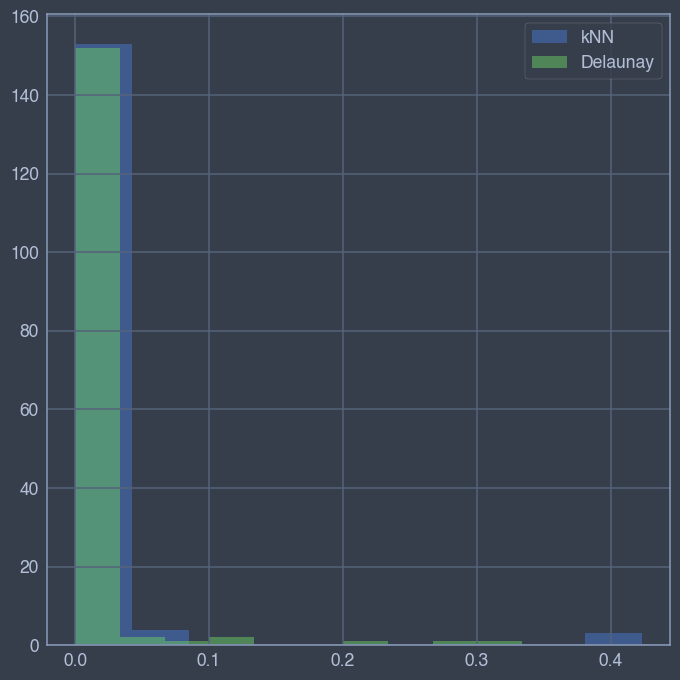

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.hist(mi_knn["pval_norm"], label="kNN", alpha=.5)
ax.hist(mi_delaunay["pval_norm"], label="Delaunay", alpha=.5)
plt.legend()
plt.tight_layout()
plt.show()
plt.close(fig)

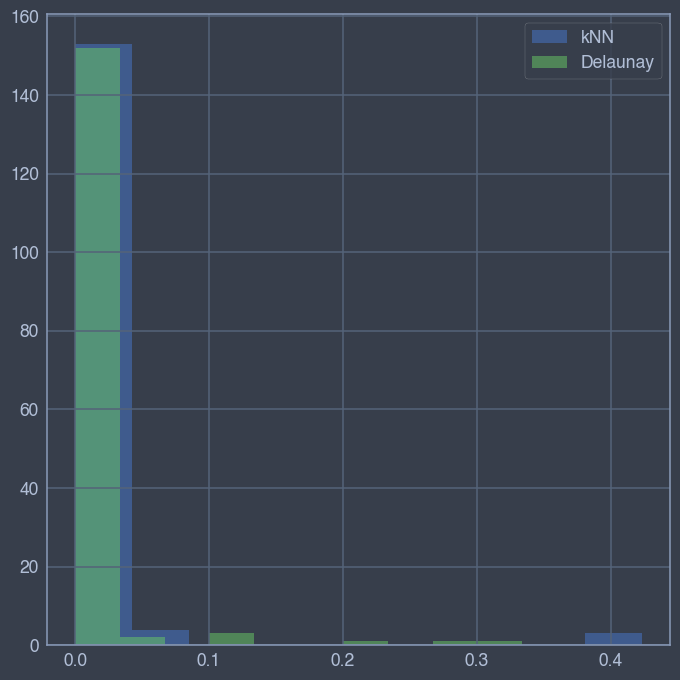

In [12]:
# => doesn't look good - no FDR correction but pval_norm_fdr_bh is all NaN => manual fdr correction
def correct_fdr(res: pd.DataFrame, pval_key: str = "pval_norm", fdr_key: str = "pval_norm_fdr_bh") -> pd.DataFrame:
    df = res.copy()
    mask = np.isnan(df[pval_key])
    df.loc[~mask, fdr_key] = fdrcorrection(df[pval_key][~mask])[1]
    return df


mi_knn = correct_fdr(mi_knn)
mi_delaunay = correct_fdr(mi_delaunay)

fig, ax = plt.subplots(figsize=(7, 7))
ax.hist(mi_knn["pval_norm_fdr_bh"], label="kNN", alpha=.5)
ax.hist(mi_delaunay["pval_norm_fdr_bh"], label="Delaunay", alpha=.5)
plt.legend()
plt.tight_layout()
plt.show()
plt.close(fig)

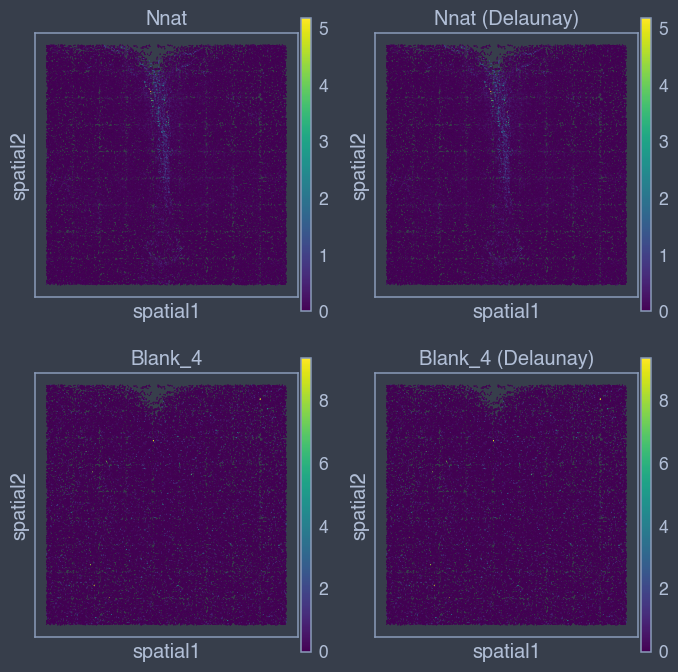

In [34]:
# TODO: choose other genes to be plotted
genes = mi_knn.index[[0, -2]]

fig, axes = plt.subplots(figsize=(7, 7), ncols=2, nrows=2)
for i, gene in enumerate(genes):
    for j, (df, met) in enumerate(zip([mi_knn, mi_delaunay], ["kNN", "Delaunay"])):
        # shape=None is necessary because merfish data does not have a pre-defined
        # shape like spot-based spatial techniques
        sq.pl.spatial_scatter(merfish, ax=axes[i, j], color=gene, shape=None, title=f"{gene} ({met})")
    axes[i, 0].set_title(gene)

plt.tight_layout()
plt.show()
plt.close(fig)

# spatial variance vs. total variance

## Co-Occurrence

Spatial co-occurrence is defined as $\frac{p(c_{t}|c_{c})}{p(c_{t})}$ i.e. the probability of observing a target cell class given the presence of a condition cell class relative to the unconditioned probability.

  0%|          | 0/1 [00:00<?, ?/s]

/opt/miniconda3/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


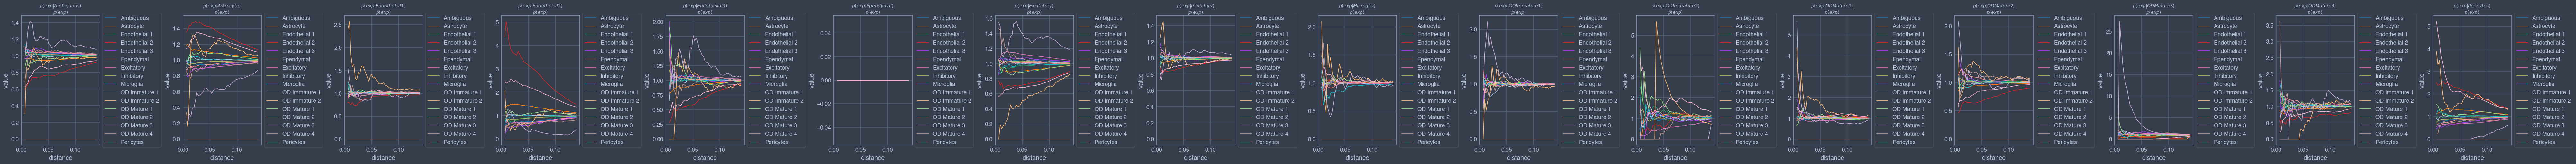

In [14]:
sq.gr.co_occurrence(merfish_subset, cluster_key="Cell_class")
sq.pl.co_occurrence(merfish_subset, cluster_key="Cell_class")

/opt/miniconda3/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


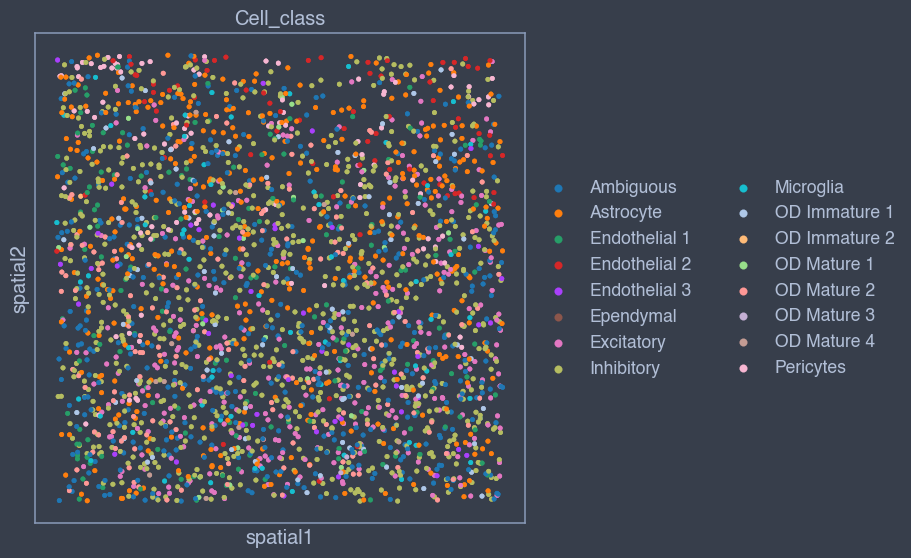

In [15]:
sq.pl.spatial_scatter(merfish_subset, color="Cell_class", shape=None, figsize=(9, 9))

## Neighborhood Enrichment

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/miniconda3/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/lib/python3.12/site-packages/squidpy/gr/_nhood.py:202: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


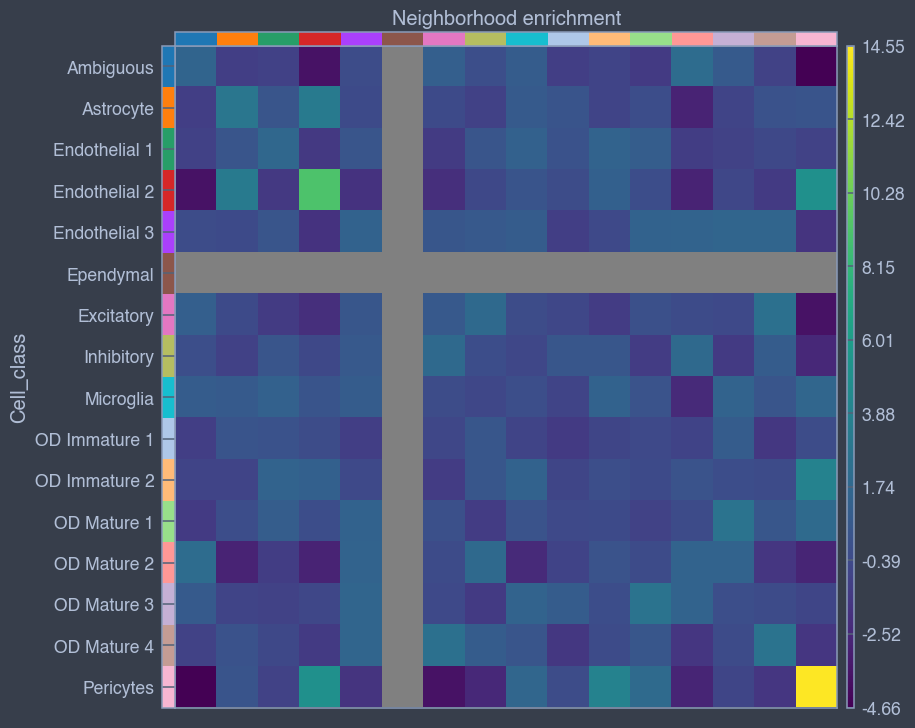

In [16]:
sq.gr.nhood_enrichment(merfish_subset, cluster_key="Cell_class", connectivity_key="delaunay")
sq.pl.nhood_enrichment(merfish_subset, cluster_key="Cell_class", figsize=(7, 7))

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/miniconda3/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/lib/python3.12/site-packages/squidpy/gr/_nhood.py:202: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


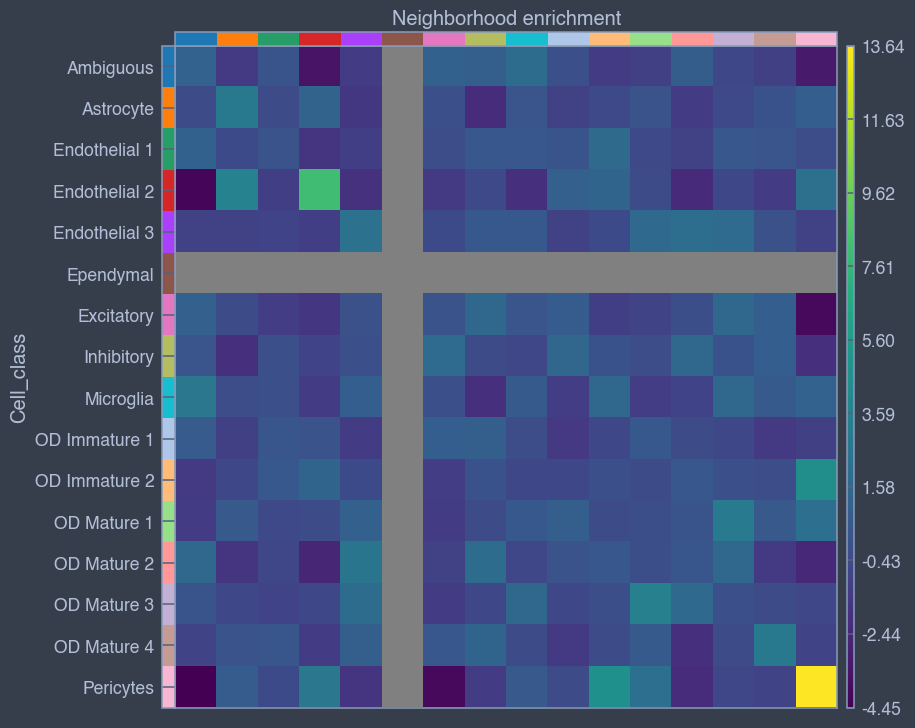

In [17]:
sq.gr.nhood_enrichment(merfish_subset, cluster_key="Cell_class", connectivity_key="spatial")
sq.pl.nhood_enrichment(merfish_subset, cluster_key="Cell_class", figsize=(7, 7))